In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
index["market_cap"] = index["market_cap"].astype(float)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code").sort_values("market_cap",ascending=False)

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [21]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.5])

In [30]:
additional_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.grouping_type.value != "sic_description":
        for member in Indicator:
            pm = copy.deepcopy(portfolio)
            pm.ranking_metric = member.label
            additional_portfolios.append(pm)

In [38]:
analysises = []
for rolling_window in [20,40,60,100]:
    market.connect()
    prices = []
    for ticker in tqdm(index["ticker"]): 
        try:
            price = market.query("prices", {"ticker": ticker})
            if price.index.size > 150:
                price = p.lower_column(price)
                price = p.utc_date(price)
            
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                for member in Indicator:
                    price = member.calculate(price,timeframe=rolling_window)
                for member in RiskType:
                    price = member.apply(price)
                prices.append(price.dropna())
        except Exception as e:
            print(str(e))
            continue
    market.disconnect()
    model_end = 2015
    backtest_end = 2025
    simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
    simulation["asset_class"] = "common_stock"
    ## subsetting backtesting data
    simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
    simulation.sort_values("date", inplace=True)
    for portfolio in tqdm(additional_portfolios):

            try:
                trades = portfolio.trades(simulation.copy())
                performance = portfolio.portfolio(trades.copy(),benchmark.copy())
                metrics = Metrics.performance(trades,performance)
                results = {**portfolio.to_dict(),**metrics.copy()}
                results["portfolio"] = portfolio
                results["rolling_window"] = rolling_window
                analysises.append(results)
            except Exception as e:
                print(str(e))
                continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [36:20<00:00, 17.03s/it]


In [39]:
a = pd.DataFrame(analysises)
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [40]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
247,247,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,1.375648e+07,5.058240,2.719617e+06,1.138108,0.874362,0.629000,1.040258,5.058238,<financial_common.portfolio_management.portfol...,40
119,119,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,6.267478e+04,5.937217,1.055626e+04,1.121023,0.898707,0.578000,1.027206,5.936720,<financial_common.portfolio_management.portfol...,20
114,114,sma,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,3.792917e+04,2.259833,1.678406e+04,1.159232,0.860763,0.569000,1.030592,2.259520,<financial_common.portfolio_management.portfol...,20
375,375,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,5.215160e+03,1.408075,3.703751e+03,1.145841,0.858446,0.586000,1.026859,1.406659,<financial_common.portfolio_management.portfol...,60
215,215,bollinger_upper,WEEK,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,4.524215e+03,2.731904,1.656066e+03,1.104704,0.909153,0.604000,1.027266,2.728737,<financial_common.portfolio_management.portfol...,40
503,503,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,1.224905e+03,0.909764,1.346399e+03,1.140760,0.851917,0.595000,1.023779,0.905868,<financial_common.portfolio_management.portfol...,100
242,242,sma,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,1.039931e+03,1.346688,7.722140e+02,1.151656,0.846198,0.588000,1.025807,1.339896,<financial_common.portfolio_management.portfol...,40
56,56,bollinger_lower,WEEK,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,1.034993e+03,4.222409,2.451192e+02,1.073190,0.926329,0.569636,1.009987,4.200882,<financial_common.portfolio_management.portfol...,20
116,116,ema,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,9.045826e+02,0.398666,2.269022e+03,1.159323,0.847240,0.566000,1.023879,0.396355,<financial_common.portfolio_management.portfol...,20
52,52,ema,WEEK,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,5.395014e+02,3.003065,1.796503e+02,1.095451,0.910064,0.548455,1.011741,2.973693,<financial_common.portfolio_management.portfol...,20


In [41]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

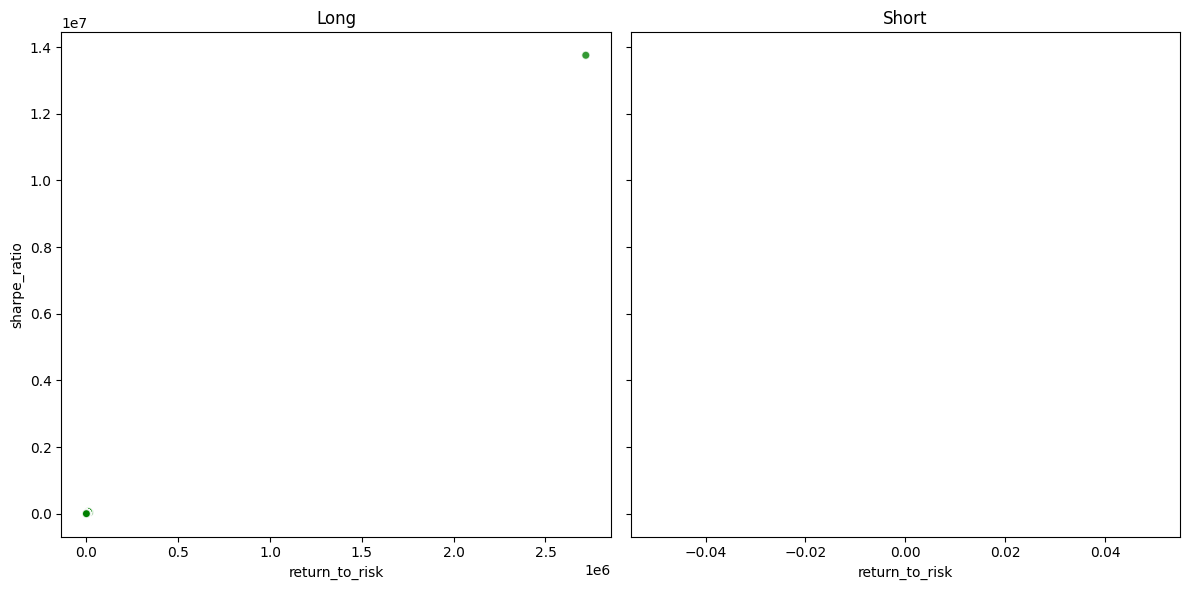

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [43]:
valid = a[(a["position_type"]=="long")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,...,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,color,return_to_risk
247,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1.375648e+07,...,2.719617e+06,1.138108,0.874362,0.629000,1.040258,5.058238,<financial_common.portfolio_management.portfol...,40,green,5.058240
119,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,6.267478e+04,...,1.055626e+04,1.121023,0.898707,0.578000,1.027206,5.936720,<financial_common.portfolio_management.portfol...,20,green,5.937217
114,sma,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,3.792917e+04,...,1.678406e+04,1.159232,0.860763,0.569000,1.030592,2.259520,<financial_common.portfolio_management.portfol...,20,green,2.259833
375,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,5.215160e+03,...,3.703751e+03,1.145841,0.858446,0.586000,1.026859,1.406659,<financial_common.portfolio_management.portfol...,60,green,1.408075
215,bollinger_upper,WEEK,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,4.524215e+03,...,1.656066e+03,1.104704,0.909153,0.604000,1.027266,2.728737,<financial_common.portfolio_management.portfol...,40,blue,2.731904
503,bollinger_upper,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1.224905e+03,...,1.346399e+03,1.140760,0.851917,0.595000,1.023779,0.905868,<financial_common.portfolio_management.portfol...,100,green,0.909764
242,sma,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1.039931e+03,...,7.722140e+02,1.151656,0.846198,0.588000,1.025807,1.339896,<financial_common.portfolio_management.portfol...,40,green,1.346688
56,bollinger_lower,WEEK,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1.034993e+03,...,2.451192e+02,1.073190,0.926329,0.569636,1.009987,4.200882,<financial_common.portfolio_management.portfol...,20,green,4.222409
116,ema,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,9.045826e+02,...,2.269022e+03,1.159323,0.847240,0.566000,1.023879,0.396355,<financial_common.portfolio_management.portfol...,20,green,0.398666
52,ema,WEEK,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,5.395014e+02,...,1.796503e+02,1.095451,0.910064,0.548455,1.011741,2.973693,<financial_common.portfolio_management.portfol...,20,green,3.003065


In [44]:
top = valid.head(1).to_dict("records")[0]
top

{'ranking_metric': 'bollinger_upper',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'long_short',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 'pnl': 13756475.586681617,
 'coefficient_of_variation': 5.0582398975760015,
 'portfolio_std': 2719617.0733764456,
 'average_gain': 1.1381081104493451,
 'average_loss': 0.8743615103755997,
 'win_loss_ratio': 0.629,
 'weekly_return': 1.0402581218219855,
 'sharpe_ratio': 5.058237969109224,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1ffb7347b90>,
 'rolling_window': 40,
 'color': 'green',
 'return_to_risk': 5.0582398975760015}

In [47]:
pm = top["portfolio"]
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [03:40<00:00, 18.18it/s]


In [48]:
portfolio

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
0,2015-01-09 00:00:00+00:00,1.387987,1.387987,45.069047,1.000000,2015,1,1,2
1,2015-01-16 00:00:00+00:00,1.294571,1.796847,42.479134,0.942535,2015,1,1,3
2,2015-01-23 00:00:00+00:00,1.024934,1.841650,43.048763,0.955174,2015,1,1,4
3,2015-01-30 00:00:00+00:00,0.889184,1.637566,41.301901,0.916414,2015,1,1,5
4,2015-02-06 00:00:00+00:00,0.867318,1.420290,43.967764,0.975565,2015,2,1,6
...,...,...,...,...,...,...,...,...,...
501,2024-11-22 00:00:00+00:00,0.988818,1091.838529,247.266698,5.486397,2024,11,4,47
502,2024-11-29 00:00:00+00:00,1.016955,1110.350626,248.430657,5.512223,2024,11,4,48
503,2024-12-06 00:00:00+00:00,1.192076,1323.622186,246.082842,5.460130,2024,12,4,49
504,2024-12-13 00:00:00+00:00,1.070573,1417.033869,238.701152,5.296343,2024,12,4,50


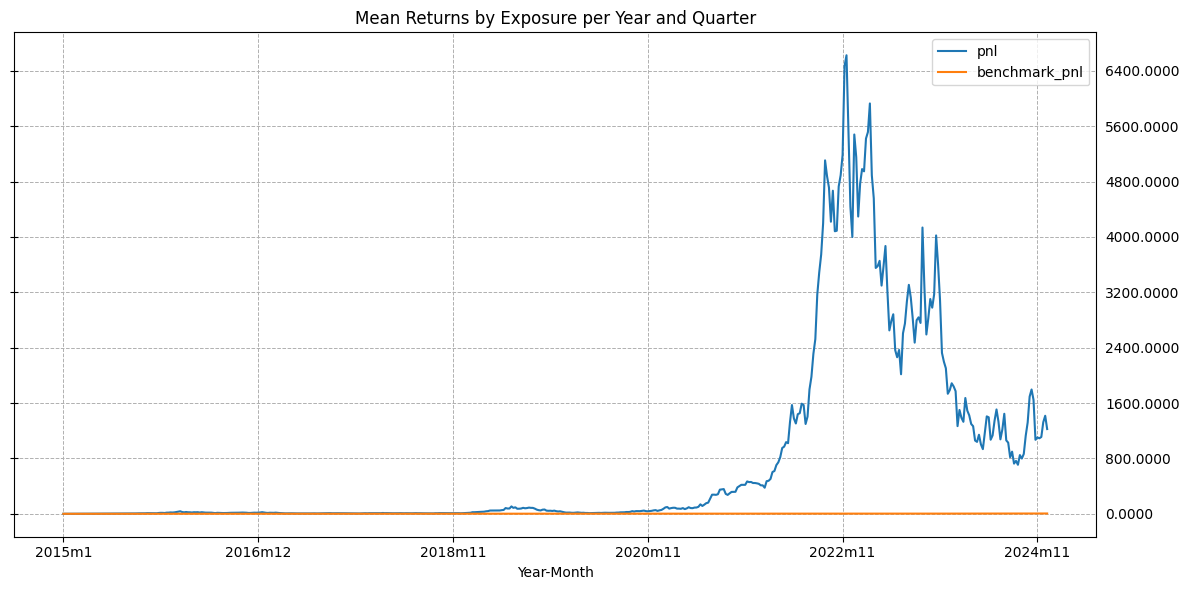

In [49]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [50]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
YYAI,1.500000
UGRO,1.500000
SNWV,1.500000
UAVS,1.500000
LINC,1.500000
...,...
ASPI,0.654908
MDGL,0.653293
LUMN,0.612766


In [51]:
trades.sort_values("date",ascending=False).dropna()

,year,week,ticker,date,adjclose,sell_price,asset_class,bollinger_upper,coefficient_of_variation,risk,...,group_percentile,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,quarter
494,2024,51,NUWE,2024-12-20 00:00:00+00:00,1.190000,1.00000,common_stock,522.087779,186.613226,186.613226,...,0.0,1.0,1,0.840336,0.840336,0.840336,"Nuwellis, Inc. Common Stock",4.085724e+06,12,4
994,2024,51,RGTI,2024-12-20 00:00:00+00:00,8.430000,9.37000,common_stock,0.569792,0.977588,0.977588,...,1.0,-1.0,1,0.888493,0.888493,0.888493,"Rigetti Computing, Inc. Common Stock",2.668919e+09,12,4
493,2024,50,NUWE,2024-12-13 00:00:00+00:00,1.340000,1.18000,common_stock,485.182599,175.374156,175.374156,...,0.0,1.0,1,0.880597,0.880597,0.880597,"Nuwellis, Inc. Common Stock",4.085724e+06,12,4
993,2024,50,SATL,2024-12-13 00:00:00+00:00,4.740000,3.50500,common_stock,0.504375,0.474063,0.474063,...,1.0,-1.0,1,1.260549,1.260549,1.260549,Satellogic Inc. Class A Ordinary Shares,3.840174e+08,12,4
991,2024,49,UMAC,2024-12-06 00:00:00+00:00,15.070000,8.71000,common_stock,0.330427,1.029052,1.029052,...,1.0,-1.0,1,1.422031,1.422031,1.422031,"Unusual Machines, Inc.",1.021591e+08,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,2015,4,DMAC,2015-01-23 00:00:00+00:00,0.980000,0.98000,common_stock,12.366343,0.733183,0.733183,...,0.0,1.0,1,1.000000,1.000000,1.000000,DiaMedica Therapeutics Inc. Common Stock,1.787081e+08,1,1
531,2015,3,AGEN,2015-01-16 00:00:00+00:00,121.099117,110.30422,common_stock,0.759760,0.161058,0.161058,...,1.0,-1.0,1,1.089141,1.089141,1.089141,Agenus Inc.,7.137093e+07,1,1
31,2015,3,ATLX,2015-01-16 00:00:00+00:00,3.000000,4.50000,common_stock,17.792055,0.548850,0.548850,...,0.0,1.0,1,1.500000,1.500000,1.500000,Atlas Lithium Corporation Common Stock,7.787012e+07,1,1
520,2015,2,JOB,2015-01-09 00:00:00+00:00,15.400000,11.15000,common_stock,0.529488,1.139630,1.139630,...,1.0,-1.0,1,1.275974,1.275974,1.275974,GEE Group Inc.,2.056969e+07,1,1
